In [1]:
!pip install -q keras_nlp==0.6.3 keras-core==0.1.7 tensorflow==2.15.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import os

os.environ["KERAS_BACKEND"] = "jax"

import keras_nlp
import keras_core as keras
import keras_core.backend as K

import tensorflow as tf

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

2024-03-29 14:39:02.215346: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 14:39:02.215434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 14:39:02.353905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using JAX backend.


In [4]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.15.0
Keras: 0.1.7
KerasNLP: 0.6.3


In [5]:
class CFG:
    """
    Configuration class containing parameters and settings for the model.
    """

    seed = 22026908  # Seed for random number generation to ensure reproducibility

    device = None  # Device to be used for training: TPU, GPU, or CPU
    replicas = None  # Number of replicas in device strategy for distributed training

    preset = "deberta_v3_base_en"  # Name of the pretrained model to be used
    sequence_length = 200  # Length of input sequences

    num_folds = 5  # Number of folds for cross-validation
    epochs = 3  # Number of epochs for training
    batch_size = 10  # Size of the batches for training
    cache = True  # Whether to cache data after one iteration for efficiency


# Set the seed for random number generation in keras to ensure reproducibility
keras.utils.set_random_seed(CFG.seed)

print(f"Config loaded | Seed: {CFG.seed}")

Config loaded | Seed: 22026908


In [6]:
def get_device():
    """
    Detects and initializes the available computing device (TPU, GPU, or CPU)
    and sets up the TensorFlow distribution strategy accordingly.

    Returns:
        tuple: A tuple containing the device type as a string and the
               TensorFlow distribution strategy.
    """
    try:
        # Attempt to detect and initialize a TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print(f"Running on TPU: {tpu.master()} | ", end="")
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f"Num of TPUs: {strategy.num_replicas_in_sync}")
        device = "TPU"
    except ValueError as e:
        # If TPU is not available or any error occurs, attempt to detect GPUs
        gpus = tf.config.list_logical_devices("GPU")
        ngpu = len(gpus)
        if ngpu > 0:
            # If GPUs are available, use the MirroredStrategy for single or multiple GPUs
            strategy = tf.distribute.MirroredStrategy(
                devices=[gpu.name for gpu in gpus]
            )
            print(f"Running on GPU | Num of GPUs: {ngpu}")
            device = "GPU"
        else:
            # Fallback to CPU if neither TPU nor GPU is available
            print("Running on CPU")
            strategy = (
                tf.distribute.get_strategy()
            )  # Default strategy that works on CPU and single GPU
            device = "CPU"
    return device, strategy


# Initialize the computing device and distribution strategy, then update CFG
CFG.device, strategy = get_device()
CFG.replicas = strategy.num_replicas_in_sync

Running on GPU | Num of GPUs: 1


In [7]:
BASE_PATH = "/kaggle/input/daigt-proper-train-dataset"

In [8]:
df = pd.read_csv(f"{BASE_PATH}/train_drcat_04.csv")
df.head()

,essay_id,text,label,source,prompt,fold
0,E897534557AF,"In recent years, technology has had a profoun...",1,mistral7binstruct_v2,\nTask: Write an essay discussing the positive...,1
1,DFBA34FFE11D,Should students participate in an extracurricu...,0,persuade_corpus,NaN,2
2,af37ecf5,The electoral college is a symbol of mockery a...,0,train_essays,NaN,5
3,5EC2696BAD78,This is why I think the principle should allow...,0,persuade_corpus,NaN,8
4,llama_70b_v1843,I strongly believe that meditation and mindful...,1,llama_70b_v1,Some schools have implemented meditation and m...,0


In [9]:
df.drop(["essay_id", "source", "prompt", "fold"], inplace=True, axis=1)
df.head()

,text,label
0,"In recent years, technology has had a profoun...",1
1,Should students participate in an extracurricu...,0
2,The electoral college is a symbol of mockery a...,0
3,This is why I think the principle should allow...,0
4,I strongly believe that meditation and mindful...,1


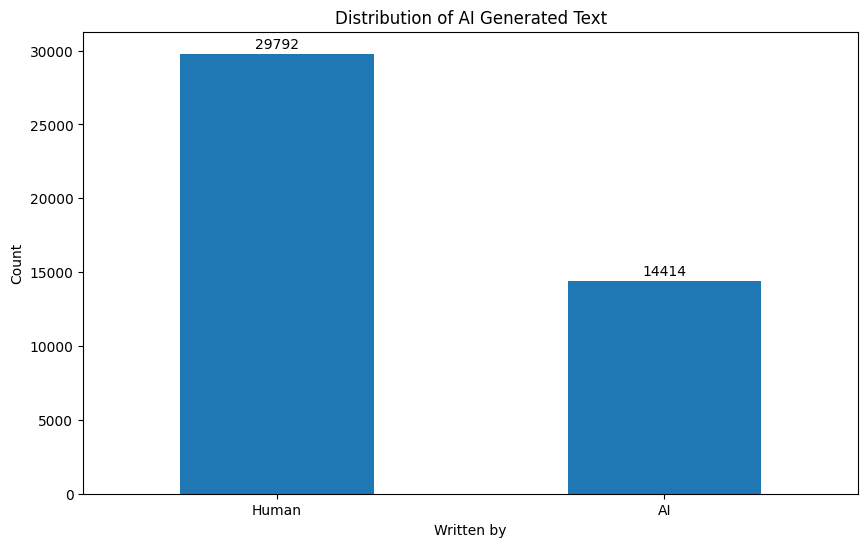

In [10]:
def plot_distribution(df):
    """
    Plots the distribution of labels in the given DataFrame.

    Parameters:
    - df: pandas.DataFrame containing a 'label' column with integer values 0 (Human) or 1 (AI).

    The function creates a bar plot showing the count of occurrences for each label.
    """
    # Create a figure and an axis with a specified size
    fig, ax = plt.subplots(figsize=(10, 6))

    # Count the occurrence of each label and plot a bar chart
    label_counts = df["label"].value_counts()
    bars = label_counts.plot(kind="bar", ax=ax)

    # Set the x and y-axis labels
    ax.set_xlabel("Written by")
    ax.set_ylabel("Count")

    # Customize the x-tick labels to clearly identify categories
    ax.set_xticklabels(["Human", "AI"], rotation=0)

    # Set the title of the plot
    ax.set_title("Distribution of AI Generated Text")

    # Annotate each bar with the count of occurrences above the bar
    for bar in bars.containers[0]:
        height = bar.get_height()  # Get the height of the bar
        ax.annotate(
            f"{int(height)}",  # Annotate with the integer count
            xy=(
                bar.get_x() + bar.get_width() / 2,
                height,
            ),  # Position at the center top of the bar
            xytext=(0, 2),  # Slightly offset above the bar
            textcoords="offset points",  # Offset from the xy position
            ha="center",  # Horizontally align at the center of the bar
            va="bottom",
        )  # Vertically align below the specified point

    # Display the plot
    plt.show()


plot_distribution(df)

In [11]:
from sklearn.utils import resample

# Count the number of instances for each label in the DataFrame
label_counts = df["label"].value_counts()

# Extract the count for the label '0' instances
label_0_count = label_counts.get(0, 0)

# Downsample instances with label '0' to half of its original count
# This is done to address class imbalance by reducing the number of '0' labeled instances
label_0_downsampled = resample(
    df[df["label"] == 0],  # Filter to only include rows where 'label' is 0
    replace=False,  # Do not allow sampling the same instance more than once
    n_samples=label_0_count // 2,  # Target number of samples is half the original count
    random_state=CFG.seed,  # Use a fixed seed for reproducibility
)

# Combine the downsampled instances with label '0' with the original instances with label '1'
# This creates a new DataFrame with a balanced distribution of labels '0' and '1'
downsampled_df = pd.concat(
    [
        label_0_downsampled,  # Downsampled '0' label instances
        df[df["label"] == 1],  # All '1' label instances
    ]
)

# Shuffle the downsampled DataFrame to mix '0' and '1' labeled instances
# This is important to ensure that the order of instances does not affect training/evaluation
df = downsampled_df.sample(frac=1, random_state=CFG.seed).reset_index(drop=True)

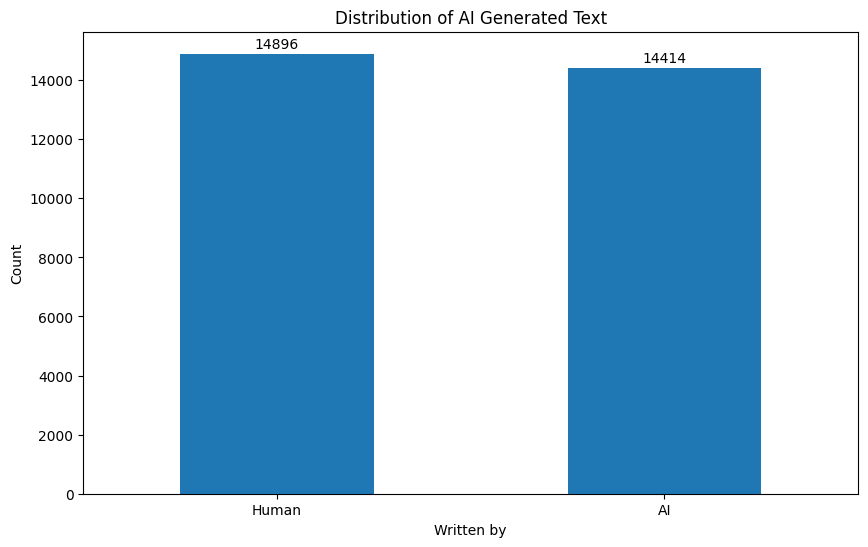

In [12]:
plot_distribution(df)

In [13]:
from sklearn.model_selection import StratifiedKFold

# Initialize StratifiedKFold to divide the data into 'num_folds' folds with shuffling
skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)

# Reset the index of the DataFrame to ensure consistent data access
df = df.reset_index(drop=True)

# Initialize a 'fold' column in the DataFrame to track which fold each row belongs to
# Start with a default value of 0 to indicate that no fold has been assigned yet
df["fold"] = 0

# Assign each instance in the DataFrame to one of the folds
# 'skf.split' yields indices for the train and validation sets for each fold
# Here, we only need the validation set indices to assign folds
for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["label"])):
    # Assign the fold number (+1 for human-readable fold numbering, starting from 1 instead of 0)
    df.loc[val_idx, "fold"] = fold + 1

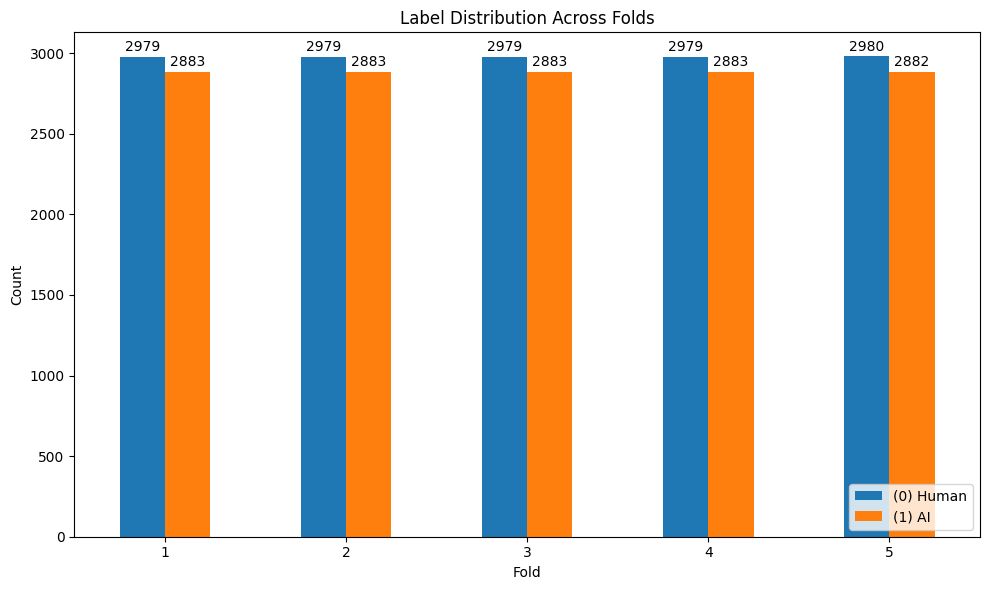

In [14]:
# Visualize the distribution of labels within each fold
# This helps to verify that the stratification works as intended by showing a balanced distribution
label_distribution = df.groupby(["fold", "label"]).size()

ax = label_distribution.unstack().plot(kind="bar", figsize=(10, 6))
plt.title("Label Distribution Across Folds")
plt.xlabel("Fold")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(labels=["(0) Human", "(1) AI"], loc="lower right")
plt.tight_layout()

# Annotating each bar with its respective count
for p in ax.patches:
    ax.annotate(
        f"{p.get_height()}",
        (
            p.get_x() + p.get_width() / 2.0,
            p.get_height(),
        ),
        ha="center",
        va="center",
        xytext=(0, 7),
        textcoords="offset points",
    )

plt.show()

In [15]:
# Initialize a preprocessor for the DebertaV3 model
# The preprocessor is configured according to settings defined in the CFG class
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset,
    sequence_length=CFG.sequence_length,
)

2464616/2464616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step       


In [16]:
def preprocess_fn(text, label=None):
    """
    Preprocesses the given text using a predefined preprocessor.

    Parameters:
    - text: The text to be preprocessed.
    - label: An optional label for the text.

    Returns:
    - A tuple of (preprocessed_text, label) if label is provided.
    """
    # Apply the preprocessor to the input text
    preprocessed_text = preprocessor(text)

    # Return a tuple of the preprocessed text and label if label is provided;
    # otherwise, return only the preprocessed text.
    return (preprocessed_text, label) if label is not None else preprocessed_text

In [17]:
def build_dataset(
    texts,
    labels=None,
    repeat=False,
    shuffle=False,
    cache=CFG.cache,
    batch_size=CFG.batch_size,
):
    """
    Builds a TensorFlow dataset for text (and optionally labels) with various processing steps including
    caching, shuffling, batching, and prefetching.

    Parameters:
    - texts: Iterable of texts to be processed.
    - labels: Optional iterable of labels corresponding to the texts.
    - repeat: Whether to repeat the dataset indefinitely.
    - shuffle: Whether to shuffle the dataset.
    - cache: Whether to cache the dataset after loading.
    - batch_size: Number of samples per batch.

    Returns:
    - A TensorFlow Dataset object ready for training or inference.
    """
    # Automatically tune the performance configuration
    AUTO = tf.data.AUTOTUNE

    # Prepare data slices from inputs, depending on whether labels are provided
    slices = (texts,) if labels is None else (texts, labels)

    # Create a TensorFlow Dataset from the data slices
    ds = tf.data.Dataset.from_tensor_slices(slices)

    # Cache the dataset if caching is enabled
    if cache:
        ds = ds.cache()

    # Apply preprocessing function to the dataset elements
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)

    # Repeat the dataset if repetition is enabled
    if repeat:
        ds = ds.repeat()

    # Shuffle the dataset if shuffling is enabled, and configure the dataset for performance
    if shuffle:
        ds = ds.shuffle(buffer_size=10000, seed=CFG.seed)
        options = tf.data.Options()
        options.experimental_deterministic = (
            False  # Disable deterministic ordering to improve performance
        )
        ds = ds.with_options(options)

    # Batch the dataset with the specified batch size, dropping any remainder for consistent batch sizes
    ds = ds.batch(batch_size=batch_size, drop_remainder=True)

    # Prefetch the next batch while the current batch is being processed to improve performance
    ds = ds.prefetch(AUTO)

    return ds

In [18]:
def get_datasets(fold):
    """
    Prepares training and validation datasets for a specified fold.

    Parameters:
    - fold: The fold number to use as validation set, with the remaining folds used for training.

    Returns:
    - A tuple containing two tuples: (training dataset, training DataFrame) and
                                     (validation dataset, validation DataFrame).
    """
    # Prepare training data: select all instances not in the current fold and shuffle
    train_df = df[df.fold != fold].sample(frac=1, random_state=CFG.seed)
    train_texts = train_df.text.tolist()  # Extract texts for training
    train_labels = train_df.label.tolist()  # Extract labels for training

    # Build the training dataset with repetition enabled for multiple epochs
    train_ds = build_dataset(train_texts, train_labels, repeat=True)

    # Prepare validation data: select instances in the current fold and shuffle
    valid_df = df[df.fold == fold].sample(frac=1, random_state=CFG.seed)
    valid_texts = valid_df.text.tolist()  # Extract texts for validation
    valid_labels = valid_df.label.tolist()  # Extract labels for validation

    # Build the validation dataset without repetition (typically not needed for validation)
    valid_ds = build_dataset(valid_texts, valid_labels, repeat=False)

    # Return datasets along with their corresponding DataFrames
    return (train_ds, train_df), (valid_ds, valid_df)

In [19]:
def build_model():
    """
    Builds and compiles a DebertaV3Classifier model with a sigmoid activation
    on the final layer for binary classification.

    Returns:
    - A compiled Keras model ready for training.
    """
    # Initialize a DebertaV3Classifier model from a preset configuration,
    # specifying the number of classes for binary classification.
    classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
        CFG.preset,
        preprocessor=None,  # Assuming preprocessing is handled externally
        num_classes=1,  # For binary classification
    )
    
    # Define the model inputs and logits based on the classifier
    inputs = classifier.input
    logits = classifier(inputs)

    # Add a sigmoid activation layer to convert logits to probabilities
    outputs = keras.layers.Activation("sigmoid")(logits)

    # Instantiate the final model object
    model = keras.Model(inputs, outputs)

    # Compile the model with an AdamW optimizer and binary crossentropy loss,
    # including AUC as a metric and enabling JIT compilation for performance.
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=5e-6),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.02),
        metrics=[keras.metrics.AUC(name="auc")],
        jit_compile=True  # Enable XLA compilation for improved performance
    )

    return model

In [20]:
model = build_model()

model.summary()

735557816/735557816 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ token_ids           │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ deberta_v3_classif… │ (None, 1)         │ 184,42… │ padding_mask[0][0],  │
│ (DebertaV3Classifi… │                   │         │ token_ids[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation          │ (None, 1)         │       0 │ deberta_v3_classifi… │
│ (Activation)        │                   │         │                      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 184,422,913 (703.52 MB)

 Trainable params: 184,422,913 (703.52 MB)

 Non-trainable params: 0 (0.00 B)

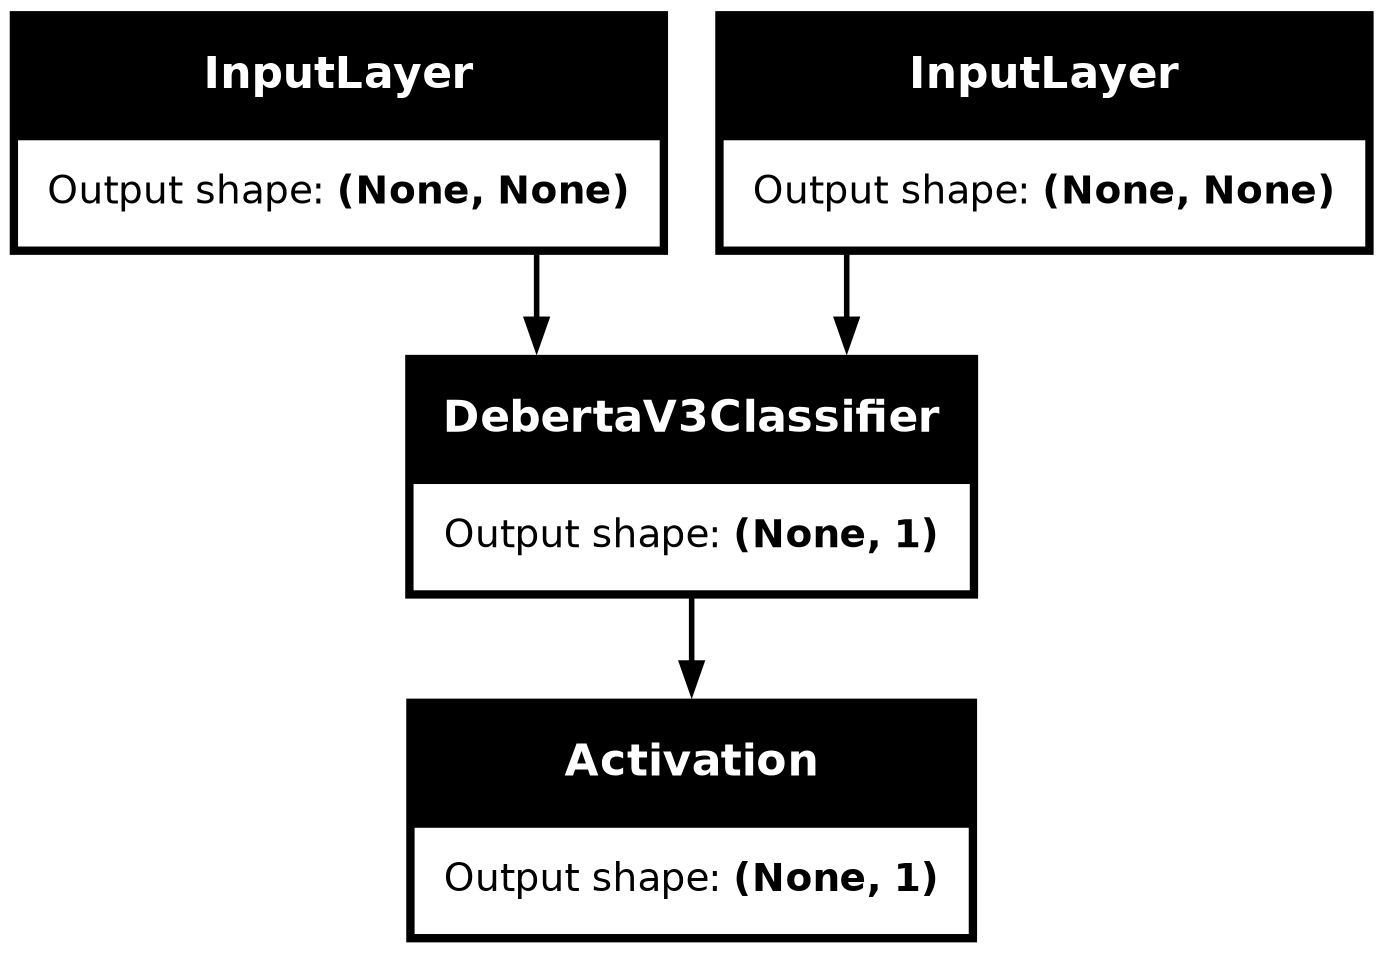

In [21]:
keras.utils.plot_model(model, show_shapes=True)

In [22]:
def cv_train(fold):
    """
    Trains a model for a given fold, evaluates it on the validation dataset,
    and prints out the training information and validation results.

    Parameters:
    - fold: The fold number (int) to train and validate the model on.

    Returns:
    - Tuple of (best_epoch, val_auc, val_loss, accuracy) for the fold.
    """
    # Retrieve training and validation datasets
    (train_ds, train_df), (valid_ds, valid_df) = get_datasets(fold)

    # Display training information
    print(f'{"=" * 15} Training Fold {fold} {"=" * 15}')
    print(f"Model: {CFG.preset} | Batch Size: {CFG.batch_size * CFG.replicas}")
    print(f"Amount train: {len(train_df)} | Amount valid: {len(valid_df)}")

    # Clear previous TensorFlow session to free resources and avoid clutter
    K.clear_session()

    # Build the model within the distributed strategy scope, if applicable
    with strategy.scope():
        model = build_model()

    # Execute model training
    history = model.fit(
        train_ds,
        epochs=CFG.epochs,
        validation_data=valid_ds,
        steps_per_epoch=int(len(train_df) / (CFG.batch_size * CFG.replicas)),
    )

    # Determine the best epoch based on validation AUC
    best_epoch = np.argmax(history.history["val_auc"])
    val_auc = history.history["val_auc"][best_epoch]
    val_loss = history.history["val_loss"][best_epoch]

    # Validation step
    print(f'\n{"=" * 15} Validating Fold {fold} {"=" * 15}')
    predictions = model.predict(valid_ds, batch_size=CFG.batch_size * CFG.replicas)

    # Calculate and print validation accuracy
    predicted_labels = (predictions > 0.5).astype(int).squeeze()
    actual_labels = valid_df.label.values[: len(predicted_labels)]
    accuracy = np.mean(predicted_labels == actual_labels)

    # Print fold results
    print(f'\n{"=" * 15} Fold {fold} Results {"=" * 15}')
    print(f"Best Epoch: {best_epoch + 1}")
    print(f"Valid AUC: {val_auc:.4f} | Valid Loss: {val_loss:.4f} | Accuracy: {accuracy:.4f}")

    return best_epoch + 1, val_auc, val_loss, accuracy

In [23]:
fold_1_results = cv_train(fold=1)

=============== Training Fold 1 ===============
Model: deberta_v3_base_en | Batch Size: 10
Amount train: 23448 | Amount valid: 5862
Epoch 1/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 860s 354ms/step - auc: 0.9818 - loss: 0.1658 - val_auc: 0.9973 - val_loss: 0.1246
Epoch 2/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 826s 352ms/step - auc: 0.9988 - loss: 0.0718 - val_auc: 0.9988 - val_loss: 0.0982
Epoch 3/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 826s 352ms/step - auc: 0.9993 - loss: 0.0672 - val_auc: 0.9990 - val_loss: 0.0885

=============== Validating Fold 1 ===============
586/586 ━━━━━━━━━━━━━━━━━━━━ 65s 101ms/step

=============== Fold 1 Results ===============
Best Epoch: 3
Valid AUC: 0.9990 | Valid Loss: 0.0885 | Accuracy: 0.9884


In [24]:
fold_2_results = cv_train(fold=2)

=============== Training Fold 2 ===============
Model: deberta_v3_base_en | Batch Size: 10
Amount train: 23448 | Amount valid: 5862
Epoch 1/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 859s 355ms/step - auc: 0.9821 - loss: 0.1648 - val_auc: 0.9982 - val_loss: 0.0899
Epoch 2/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 827s 353ms/step - auc: 0.9989 - loss: 0.0726 - val_auc: 0.9974 - val_loss: 0.0947
Epoch 3/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 829s 354ms/step - auc: 0.9992 - loss: 0.0672 - val_auc: 0.9982 - val_loss: 0.0997

=============== Validating Fold 2 ===============
586/586 ━━━━━━━━━━━━━━━━━━━━ 65s 101ms/step

=============== Fold 2 Results ===============
Best Epoch: 3
Valid AUC: 0.9982 | Valid Loss: 0.0997 | Accuracy: 0.9829


In [25]:
fold_3_results = cv_train(fold=3)

=============== Training Fold 3 ===============
Model: deberta_v3_base_en | Batch Size: 10
Amount train: 23448 | Amount valid: 5862
Epoch 1/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 862s 355ms/step - auc: 0.9775 - loss: 0.1703 - val_auc: 0.9979 - val_loss: 0.0769
Epoch 2/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 827s 353ms/step - auc: 0.9987 - loss: 0.0715 - val_auc: 0.9985 - val_loss: 0.0738
Epoch 3/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 827s 353ms/step - auc: 0.9991 - loss: 0.0679 - val_auc: 0.9985 - val_loss: 0.0831

=============== Validating Fold 3 ===============
586/586 ━━━━━━━━━━━━━━━━━━━━ 82s 130ms/step

=============== Fold 3 Results ===============
Best Epoch: 2
Valid AUC: 0.9985 | Valid Loss: 0.0738 | Accuracy: 0.9906


In [26]:
fold_4_results = cv_train(fold=4)

=============== Training Fold 4 ===============
Model: deberta_v3_base_en | Batch Size: 10
Amount train: 23448 | Amount valid: 5862
Epoch 1/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 862s 356ms/step - auc: 0.9802 - loss: 0.1721 - val_auc: 0.9987 - val_loss: 0.0977
Epoch 2/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 828s 353ms/step - auc: 0.9991 - loss: 0.0726 - val_auc: 0.9991 - val_loss: 0.0806
Epoch 3/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 828s 353ms/step - auc: 0.9994 - loss: 0.0668 - val_auc: 0.9996 - val_loss: 0.0697

=============== Validating Fold 4 ===============
586/586 ━━━━━━━━━━━━━━━━━━━━ 65s 101ms/step

=============== Fold 4 Results ===============
Best Epoch: 3
Valid AUC: 0.9996 | Valid Loss: 0.0697 | Accuracy: 0.9961


In [27]:
fold_5_results = cv_train(fold=5)

=============== Training Fold 5 ===============
Model: deberta_v3_base_en | Batch Size: 10
Amount train: 23448 | Amount valid: 5862
Epoch 1/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 863s 356ms/step - auc: 0.9762 - loss: 0.1877 - val_auc: 0.9979 - val_loss: 0.1250
Epoch 2/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 829s 354ms/step - auc: 0.9990 - loss: 0.0720 - val_auc: 0.9990 - val_loss: 0.0858
Epoch 3/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 828s 353ms/step - auc: 0.9992 - loss: 0.0683 - val_auc: 0.9990 - val_loss: 0.0846

=============== Validating Fold 5 ===============
586/586 ━━━━━━━━━━━━━━━━━━━━ 65s 101ms/step

=============== Fold 5 Results ===============
Best Epoch: 3
Valid AUC: 0.9990 | Valid Loss: 0.0846 | Accuracy: 0.9903


In [28]:
fold_results = pd.DataFrame(
    data=[
        fold_1_results,
        fold_2_results,
        fold_3_results,
        fold_4_results,
        fold_5_results,
    ],
    columns=["best_epoch", "val_auc", "val_loss", "accuracy"],
)

fold_results.insert(0, "fold", range(1, len(fold_results) + 1))

fold_results

,fold,best_epoch,val_auc,val_loss,accuracy
0,1,3,0.999048,0.088543,0.988396
1,2,3,0.998241,0.099726,0.982935
2,3,2,0.998550,0.073806,0.990614
3,4,3,0.999560,0.069685,0.996075
4,5,3,0.998976,0.084618,0.990273
